<a href="https://colab.research.google.com/github/annkamsk/ASD-problems/blob/master/Ass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import pandas as pd 
from pandas import IntervalDtype
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset

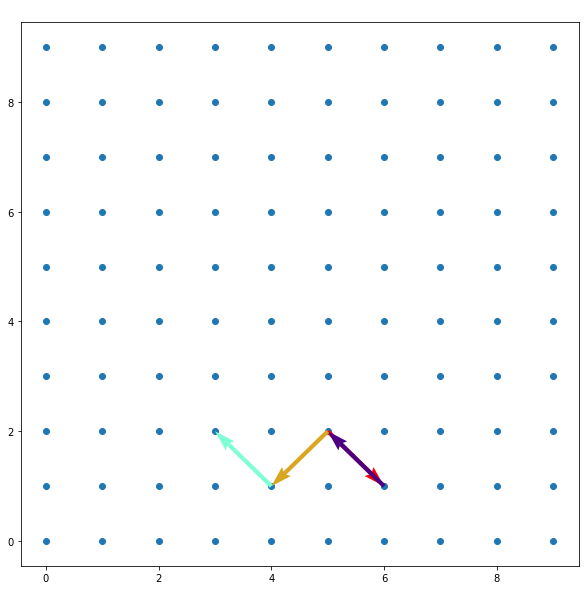

In [5]:
TRAIN_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/train_x.csv'
TRAIN_LABEL_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/train_y.csv'
TEST_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/test_x.csv'
TEST_LABEL_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/test_y.csv'
BEST_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/best.pth'

class Config:
  def __init__(self, bs=4, epochs=5, output=4, inputs=2, hidden=2, seq_len=5, layers=1):
    self.bs = bs
    self.epochs = epochs
    self.output = output
    self.inputs = inputs
    self.hidden = hidden
    self.seq_len = seq_len
    self.layers = layers


class MyDataset(Dataset):
    def __init__(self, data, col):
        self.data = data
        self.label = col

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]


train_csv = pd.read_csv(TRAIN_PATH, header=None).values
train_labels_csv = pd.read_csv(TRAIN_LABEL_PATH,header=None,dtype=np.int64).values
test_csv = pd.read_csv(TEST_PATH, header=None).values
test_labels_csv = pd.read_csv(TEST_LABEL_PATH,header=None,dtype=np.int64).values

train = []
for row in train_csv:
  train.append([[int(v) for v in val.split('-')] for val in row])
train = np.array(train)

test = []
for row in test_csv:
  test.append([[int(v) for v in val.split('-')] for val in row])
test = np.array(test)

train_torch = torch.from_numpy(train)
target_torch = torch.from_numpy(train_labels_csv)
test_torch = torch.from_numpy(test)
test_target_torch = torch.from_numpy(test_labels_csv)

train = MyDataset(train_torch, target_torch)
train_loader = DataLoader(train, batch_size = Config().bs, shuffle=True)
test = MyDataset(test_torch, test_target_torch)
test_loader = DataLoader(test, batch_size = Config().bs, shuffle=False)

def show_movement(row, label):
  xx, yy = np.meshgrid(np.arange(10), np.arange(10), indexing='ij')

  def get_mesh(row):
    V = []
    row = np.array(row)
    originX, originY = [], []
    for a, b in zip(row, row[1:]):
      originX.append(a[0])
      originY.append(a[1])
      vec = b - a
      V.append([vec[0], vec[1]])
    return np.array(V), np.array(originX), np.array(originY)

  Z, oX, oY = get_mesh(row)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(xx, yy)
  plt.quiver(oX, oY, Z[:,0], Z[:,1], color=['r','indigo','goldenrod','aquamarine'], angles='xy', scale_units='xy', scale=1)
  plt.title(label, color='w')
  plt.show()

items = iter(train_loader).next()
show_movement(items[0][0], items[1][0])


## Data analysis
3: LD, RG, RD, LG  (to the bottom left?)  
1: (to the upper left), RD, RG, LG, LG; LD, LG, LD, LG  
0: (to the upper right?), LG, RG, RG, RD; RGx4    
2: (to bottom right) RG, LG, RD, LD; 
RD, RD, LD, RD; 
RD, LG, RG, RG  

In [0]:
import random

class RNNet(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, bs, layers=1, trunc=False):
    super(RNNet, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.layers = layers
    self.hidden_dim = hidden_dim
    self.bs = bs
    self.trunc = trunc
    random.seed()

    self.lstm = nn.LSTM(
        input_size=input_size, 
        hidden_size=hidden_dim, 
        num_layers=layers,
        batch_first=True)
    self.seq = nn.Linear(hidden_dim, output_size)
    # nn.Sequential(
    #     nn.Linear(hidden_dim, hidden_dim),
    #     nn.ReLU(True),
    #     nn.Linear(hidden_dim, hidden_dim),
    #     nn.ReLU(True),
    #     nn.Linear(hidden_dim, output_size)
    # )
  
  def init_hidden(self):
    h = Variable(torch.zeros(self.layers, self.bs, self.hidden_dim).cuda())
    c = Variable(torch.zeros(self.layers, self.bs, self.hidden_dim).cuda())
    return (h, c)

  def pad_input(self, x):
    if self.trunc and random.random() >= 0.5:
      x = x[:,:4,:]
      seq_lengths = [4] * self.bs
    else:
      seq_lengths = [5] * self.bs
    res = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True)
    return res

  def forward(self, x):
    x = x.float()    
    lstm_input = self.pad_input(x)
    # x = (bs, seq_len=5, feature=2)
    lstm_out, hidden = self.lstm(lstm_input, self.init_hidden())
    lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
    y = self.seq(lstm_out[:, -1, :])
    return y


- input dimension: nr of variables (2)
- hidden dimension: size of hidden and cell state at each time step
- nr of layers (default 1)
- output dimension: nr of classes (4)
lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

## Raw data

In [139]:
conf = Config(bs=4, epochs=1, output=4, inputs=2, hidden=256, seq_len=5, layers=1)
model = RNNet(conf.inputs, conf.output, conf.hidden, conf.bs, conf.layers)
model.cuda()
lr = 0.0005
optimizer = optim.RMSprop(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def test(model):
  correct, total = 0., 0.
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    out = model(data)
    preds = F.log_softmax(out, dim=1).argmax(dim=1)
    total += target.size(0)
    correct += (preds == target.squeeze()).sum().item()
  return correct / total


def train(epoch, best):
  total, total_correct = 0., 0.
  for idx, (data, target) in enumerate(train_loader):
    model.train()
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target.squeeze())
    loss.backward()
    optimizer.step()

    if idx % 100 == 0:
      model.eval()
      acc = test(model)
      print('Train epoch {}, idx: {}\t Loss {:.4f}\t Acc: {:.2f}%'.format(
          epoch,
          idx,
          loss.item(),
          acc * 100
      ))
      if acc > best:
        best = acc
        torch.save(model.state_dict(), BEST_PATH)

best = 0.0
for epoch in range(conf.epochs):
  train(epoch, best)

Train epoch 0, idx: 0	 Loss 1.3927	 Acc: 24.90%
Train epoch 0, idx: 100	 Loss 1.2323	 Acc: 38.10%
Train epoch 0, idx: 200	 Loss 1.2816	 Acc: 50.90%
Train epoch 0, idx: 300	 Loss 1.0701	 Acc: 56.70%
Train epoch 0, idx: 400	 Loss 0.9079	 Acc: 51.90%
Train epoch 0, idx: 500	 Loss 0.5511	 Acc: 57.30%
Train epoch 0, idx: 600	 Loss 0.6336	 Acc: 58.70%
Train epoch 0, idx: 700	 Loss 0.7847	 Acc: 57.70%
Train epoch 0, idx: 800	 Loss 0.8105	 Acc: 59.70%
Train epoch 0, idx: 900	 Loss 1.5421	 Acc: 64.00%
Train epoch 0, idx: 1000	 Loss 0.8397	 Acc: 61.90%
Train epoch 0, idx: 1100	 Loss 1.3056	 Acc: 62.30%
Train epoch 0, idx: 1200	 Loss 0.6520	 Acc: 62.90%
Train epoch 0, idx: 1300	 Loss 0.6856	 Acc: 62.00%
Train epoch 0, idx: 1400	 Loss 0.9661	 Acc: 61.30%
Train epoch 0, idx: 1500	 Loss 1.0943	 Acc: 64.60%
Train epoch 0, idx: 1600	 Loss 1.0478	 Acc: 63.50%
Train epoch 0, idx: 1700	 Loss 1.4710	 Acc: 62.50%
Train epoch 0, idx: 1800	 Loss 0.8562	 Acc: 64.00%
Train epoch 0, idx: 1900	 Loss 1.2888	 Acc: